### Mechanics of PyTorch Linear model/layer

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
x = torch.tensor([[1., -2, 0]])
x += 0
print(x.shape)
F.softmax(x, dim=1)

torch.Size([1, 3])


tensor([[0.7054, 0.0351, 0.2595]])

In [3]:
lin = nn.Linear(2, 3) # maps from R^2 to R^3, parameters A, b
print(lin)

Linear(in_features=2, out_features=3, bias=True)


In [4]:
lin.weight.data, lin.bias.data

(tensor([[-0.6758, -0.1919],
         [ 0.0083,  0.4036],
         [-0.0292,  0.4011]]),
 tensor([-0.4405,  0.2681, -0.0209]))

In [5]:
lin.weight.data = torch.tensor([[1., 2], [3, 4], [5, 6]])
lin.bias.data = torch.tensor([1., 2, 3])
lin.weight.data, lin.bias.data

(tensor([[1., 2.],
         [3., 4.],
         [5., 6.]]),
 tensor([1., 2., 3.]))

In [6]:
x = torch.tensor([[1., -2]])
lin(x)

tensor([[-2., -3., -4.]], grad_fn=<AddmmBackward0>)

In [7]:
# Create a 4x2 tensor
x = torch.tensor([[1., -2], [3, 4], [5, 6], [7, 8]])
x, lin(x)

(tensor([[ 1., -2.],
         [ 3.,  4.],
         [ 5.,  6.],
         [ 7.,  8.]]),
 tensor([[-2., -3., -4.],
         [12., 27., 42.],
         [18., 41., 64.],
         [24., 55., 86.]], grad_fn=<AddmmBackward0>))

In [8]:
x @ lin.weight.t() + lin.bias # This is what lin(x) does

tensor([[-2., -3., -4.],
        [12., 27., 42.],
        [18., 41., 64.],
        [24., 55., 86.]], grad_fn=<AddBackward0>)

In [9]:
# torch class for softmax regression
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
        
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)

In [10]:
torch.manual_seed(5576)

# Consider a 2D input and 5 classes
true_model = SoftmaxRegression(2, 4)
print(true_model)
print(list(true_model.parameters()))

# true_model.linear.weight.data = torch.tensor([[1., 1], [-1, 1], [1, -1], [-1, -1]])
# true_model.linear.bias.data = torch.tensor([1., 1, 1, 1])

# # multiply model parameters by 10
# for param in true_model.parameters():
#     param.data *= 10
# list(true_model.parameters())

SoftmaxRegression(
  (linear): Linear(in_features=2, out_features=4, bias=True)
)
[Parameter containing:
tensor([[-0.5109, -0.4787],
        [ 0.5604,  0.2671],
        [-0.0978,  0.1737],
        [ 0.4519,  0.5037]], requires_grad=True), Parameter containing:
tensor([-0.2988, -0.6194, -0.2270, -0.3060], requires_grad=True)]


In [11]:
n_train = 2000
X = torch.randn(n_train, 2)
prob = true_model(X)
print(prob.shape)
prob

torch.Size([2000, 4])


tensor([[0.1040, 0.2256, 0.2661, 0.4043],
        [0.3640, 0.1396, 0.2975, 0.1989],
        [0.4302, 0.1269, 0.2775, 0.1654],
        ...,
        [0.4157, 0.1777, 0.2322, 0.1745],
        [0.5508, 0.0940, 0.2430, 0.1121],
        [0.3350, 0.1599, 0.2883, 0.2168]], grad_fn=<SoftmaxBackward0>)

In [12]:
# Generate y from prob
y = torch.distributions.Categorical(prob).sample()
# y = torch.multinomial(prob, 1).squeeze()

<Figure size 500x500 with 0 Axes>

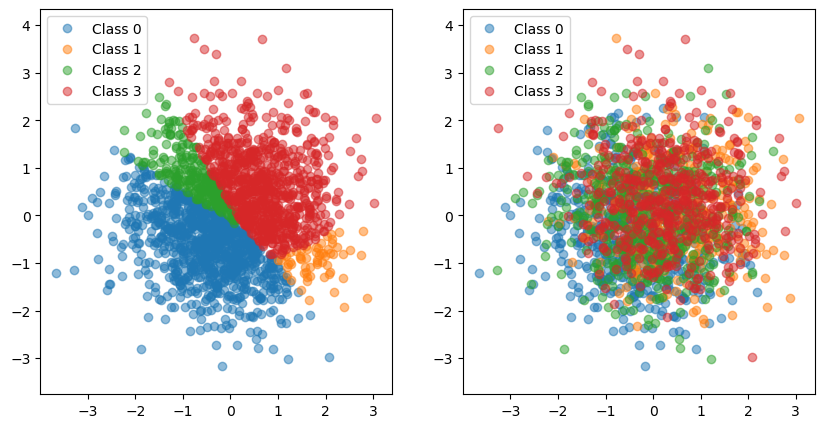

In [13]:
# Get class of y (Bayes classifier)
y_class = torch.argmax(prob, dim=1)

import matplotlib.pyplot as plt

# Plot X colored by y_class
plt.figure(figsize=(5,5))

# Write plot_points function
def plot_points(y, X):
    """Plot points X colored by y."""
    # Get unique classes
    classes = torch.unique(y)
    # Plot each class
    for c in classes:
        # Get indices of points with class c
        idx = y == c
        # Plot points with class c
        plt.plot(X[idx, 0], X[idx, 1], 'o', label=f'Class {c}', alpha=0.5)
    plt.legend()
    plt.axis('equal')

# Create a figure with 2 subplots
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plot_points(y_class, X)
plt.subplot(1, 2, 2)
plot_points(y, X)


In [14]:
model = SoftmaxRegression(2, 4)

optim = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.)

def my_loss(model):
    """Compute the loss of model on y."""
    # Compute the probability of each class
    prob = model(X)
    # Compute the log probability of the correct class
    log_prob = torch.log(prob[range(n_train), y])
    # Compute the normalized negative log likelihood
    loss = -torch.mean(log_prob)
    return loss


In [15]:
# Verify that torch SGD is doing what we expect

# Compute the loss of model on y
loss = my_loss(model)
print(loss)

print("--- Gradient of model parameters before backward pass:")
for name, param in model.named_parameters():
    print(name, ':\n  ', param.grad)

loss.backward()

print("--- Gradient of model parameters after backward pass")
for name, param in model.named_parameters():
    print(name, ':\n  ', param.grad)

tensor(1.7834, grad_fn=<NegBackward0>)
--- Gradient of model parameters before backward pass:
linear.weight :
   None
linear.bias :
   None
--- Gradient of model parameters after backward pass
linear.weight :
   tensor([[ 0.1377,  0.2301],
        [-0.1380, -0.0246],
        [ 0.1457, -0.0612],
        [-0.1453, -0.1443]])
linear.bias :
   tensor([-0.1397, -0.0303,  0.2215, -0.0515])


In [16]:
print("--- Our own gradient step")
print(model.linear.weight - 0.2*model.linear.weight.grad)
print(model.linear.bias - 0.2*model.linear.bias.grad)

# Take a gradient step
optim.step()

print("--- Torch's gradient step")
print(model.linear.weight)
print(model.linear.bias)

--- Our own gradient step
tensor([[-0.0761,  0.5383],
        [-0.3807, -0.0549],
        [ 0.1294, -0.1827],
        [-0.4516, -0.3584]], grad_fn=<SubBackward0>)
tensor([-0.5327, -0.5101,  0.6030, -0.3107], grad_fn=<SubBackward0>)
--- Torch's gradient step
Parameter containing:
tensor([[-0.0761,  0.5383],
        [-0.3807, -0.0549],
        [ 0.1294, -0.1827],
        [-0.4516, -0.3584]], requires_grad=True)
Parameter containing:
tensor([-0.5327, -0.5101,  0.6030, -0.3107], requires_grad=True)


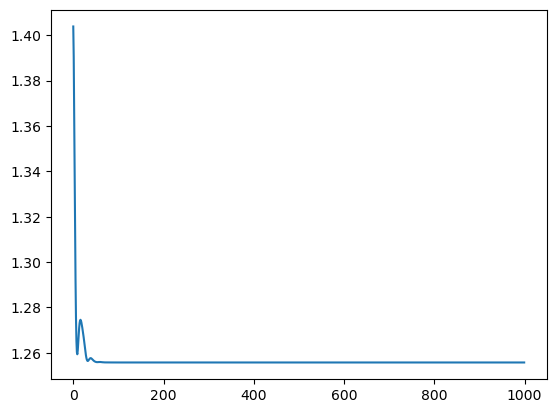

In [17]:
model = SoftmaxRegression(2, 4) # Initialize model

optim = torch.optim.SGD(model.parameters(), lr=.2, momentum=0.9)

n_steps = 1000

# Run gradient descent
loss_hist = []
for iter in range(n_steps):
    # Compute the loss
    loss = my_loss(model)
    # Compute the gradient of the loss
    loss.backward()
    # Update the parameters
    optim.step()
    # Set the gradient to zero
    optim.zero_grad()
    # Save the loss
    loss_hist.append(loss.item())

plt.plot(loss_hist)

In [18]:
# compare with true model
print(true_model.linear.weight)
print(model.linear.weight)

Parameter containing:
tensor([[-0.5109, -0.4787],
        [ 0.5604,  0.2671],
        [-0.0978,  0.1737],
        [ 0.4519,  0.5037]], requires_grad=True)
Parameter containing:
tensor([[-0.7495, -0.4018],
        [ 0.3192,  0.3215],
        [-0.3730,  0.1327],
        [ 0.1185,  0.5230]], requires_grad=True)


In [19]:
# compute the accuracy of the model
prob = model(X)
y_class = torch.argmax(prob, dim=1)
print(torch.mean((y_class == y).float()))

# compute Bayes accuracy
prob = true_model(X)
y_class = torch.argmax(prob, dim=1)
print(torch.mean((y_class == y).float()))

tensor(0.4080)
tensor(0.4065)


In [20]:
list(model.parameters()), list(true_model.parameters())

([Parameter containing:
  tensor([[-0.7495, -0.4018],
          [ 0.3192,  0.3215],
          [-0.3730,  0.1327],
          [ 0.1185,  0.5230]], requires_grad=True),
  Parameter containing:
  tensor([-0.0786, -0.5264, -0.0652, -0.1959], requires_grad=True)],
 [Parameter containing:
  tensor([[-0.5109, -0.4787],
          [ 0.5604,  0.2671],
          [-0.0978,  0.1737],
          [ 0.4519,  0.5037]], requires_grad=True),
  Parameter containing:
  tensor([-0.2988, -0.6194, -0.2270, -0.3060], requires_grad=True)])

In [21]:
model.linear.weight.data - true_model.linear.weight.data

tensor([[-0.2385,  0.0769],
        [-0.2412,  0.0545],
        [-0.2752, -0.0409],
        [-0.3335,  0.0193]])